# Quick Start

Here's a quick tutorial for those in a rush!

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import hemcee

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True) # JAX defaults to float32

import numpy as np
import corner

First, specifiy the log probability (doesn't have to be normalized)
of your target distribution.
In this case, let's start with a simple Gaussian.

In [3]:
def log_prob(x):
    return - 0.5 * jnp.einsum('j,j->', x, x)

Now we can initalize the sampler. There are two types of samplers 
- `hemcee.HamiltonianEnsembleSampeler` which implements the derivative-based algorithms detailed in [Y. Chen (2025)](https://arxiv.org/abs/2505.02987).
- `hemcee.EnsembleSampler` which implements the derivative-free algorithms detailed in [Goodman & Weare (2010)](https://msp.org/camcos/2010/5-1/camcos-v5-n1-p04-s.pdf). This package is meant to mimic the synatx of [emcee](https://emcee.readthedocs.io/en/stable/)

Let's start with the novel part of this package...

## `HamiltonianEnsembleSampler`
In Chen's paper, he details a couple of affine invariant sampling scheme. He comes to the conclusion that the walk move (Algorithm 3 in [Y. Chen (2025)](https://arxiv.org/abs/2505.02987)) performs the best overall, so our package defaults to that.

In [4]:
dim = 3
total_chains = 20

# Inintalize the sampler
sampler = hemcee.HamiltonianEnsembleSampler(
    total_chains=total_chains,
    dim=dim, # <- dimension of the probability distribution
    log_prob=log_prob, # <- log probability goes here!
)

Now, we can run the sampler!

In [5]:
key = jax.random.PRNGKey(2)
keys = jax.random.split(key, 2)

# Initial states for mcmc algorithm
inital_states = jax.random.normal(keys[0], shape=(total_chains, dim)) 

samples = sampler.run_mcmc(
    key=keys[1], # <- JAX is used under the hood, so we need to pass in a `key`
    initial_state=inital_states,
    num_samples=10**4,
    warmup=10**5,
    thin_by=1,
    show_progress=True, # <- Shows a progress bar
)

Using 20 total chains: Group 1 (10), Group 2 (10)
Using inital step size of 1.6
Starting warmup...


100%|██████████| 603/603 [00:10<00:00, 58.49it/s]


Warmup complete.
Found step size 0.10160634057813525 and integration length: 23
Starting main sampling...


100%|██████████| 61/61 [00:01<00:00, 34.62it/s]

Main sampling complete.


You'll notice there's a lot of parameters spit out here. Let's break it down.

Hamiltonian samplers make proposals using Hamiltonian dynamics, where the potential is taken to be the negatively log probability (unormalized) of your target distribution. There's a lot of headache involved with selecting an appropriate step size and integration length. We have included (affine-invariant) autotuners to make your life easier.

Before we start the warmup run, we select an inital step size which yields ~ 80% acceptance rate (for 1 integration step). This is the first print statement. From there we use the `Dual Averaging` and (affine-invariant modification) `ChEES` algorithms to tune the step size and integration length respectively. This is the second print statement.

To learn more about adapters please look at the adaptation tutorial.

Diagnostics:
[0.9992 0.9991 0.9993 0.9991 0.9994 0.9989 0.9988 0.9992 0.9991 0.9985
 0.9993 0.9988 0.9991 0.9989 0.9991 0.9994 0.999  0.9988 0.9995 0.9985]
Integrated autocorrelation time:
[0.4727686  0.4846164  0.46748046]


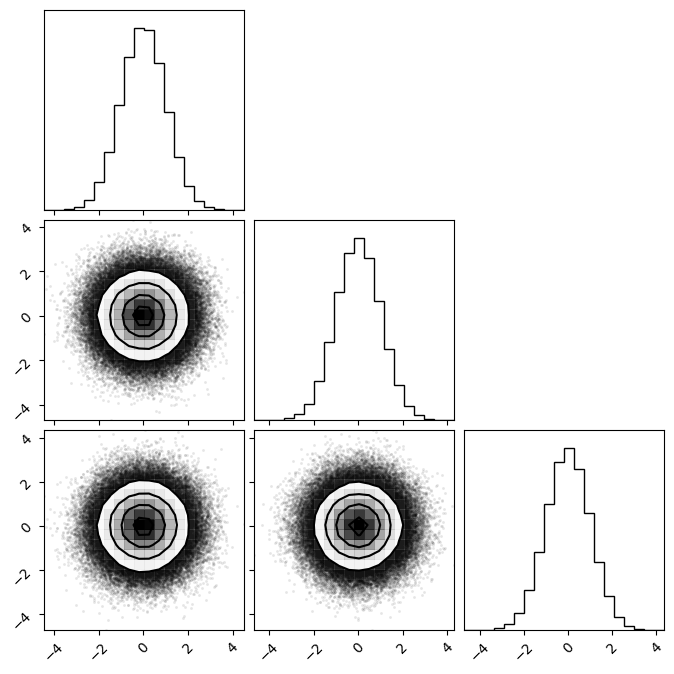

In [6]:
print('Diagnostics:')
print(sampler.diagnostics_main['acceptance_rate'])

tau = hemcee.autocorr.integrated_time(samples)
print('Integrated autocorrelation time:')
print(tau)

# Visualize results using dfm's `corner`
_ = corner.corner(samples.reshape(-1, dim).__array__())

## `EnsembleSampler`

If you're feeling old school (or derivatives are very expensive for you), you can use the sampler in `emcee.EnsembleSampler`. In our package you can access this via the `hemcee.EnsembleSampler` class.

In [7]:
from hemcee.moves.vanilla.stretch import stretch_move

sampler = hemcee.EnsembleSampler(
    total_chains=total_chains,
    dim=dim,
    log_prob=log_prob,
    move=stretch_move, # Defaults to `stretch_move`, which is the default in `emcee`
)

samples = sampler.run_mcmc(
    key=jax.random.PRNGKey(0),
    initial_state=inital_states,
    num_samples=10**4,
    warmup=10**5,
    thin_by=1,
    show_progress=True,
)

tau = hemcee.autocorr.integrated_time(samples)
print('Integrated autocorrelation time:')
print(tau)


Using 20 total chains: Group 1 (10), Group 2 (10)


100%|██████████| 663/663 [00:04<00:00, 132.92it/s]

Integrated autocorrelation time:
[38.06386299 43.37061421 42.31482191]


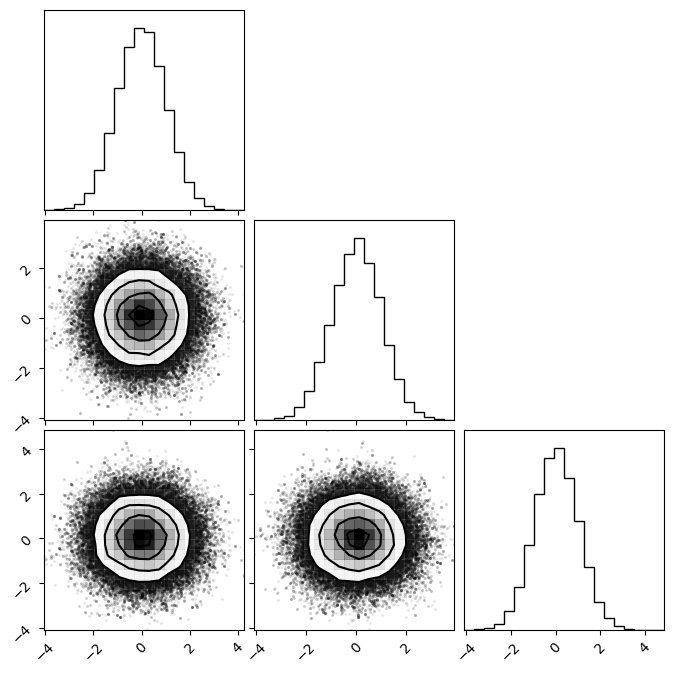

In [8]:
n_show = 100000 # Makes plotting faster
_ = corner.corner(samples.reshape(-1, dim).__array__())

Looking at the integrated autocorrelation time, we can see the `HamiltonianEnsembleSampler` outperforms the `EnsembleSampler` by a large margin! Visually we can confirm this as the Gaussian plotted here is more jaggidy in comparison the one sampled in the previous section.